In [1]:
import numpy as np
import keras
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM,Bidirectional
import re
import tensorflow as tf
from keras.preprocessing.text import Tokenizer

In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool1D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df=pd.read_excel('/content/drive/MyDrive/Thesis/Datasets/Bert_Preprocessed_Dataset.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6405 entries, 0 to 6404
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  6405 non-null   int64 
 1   ID          6404 non-null   object
 2   Text        6404 non-null   object
 3   Sentiment   6405 non-null   object
 4   Label       6405 non-null   int64 
 5   Token       6405 non-null   object
 6   Token_ID    6405 non-null   object
dtypes: int64(2), object(5)
memory usage: 350.4+ KB


In [5]:
df.head()

,Unnamed: 0,ID,Text,Sentiment,Label,Token,Token_ID
0,479,939195189512152_939206382844366,উনারে লাথথায়ে মিরপুর চিড়িয়াখানার প্রধান সিকিউর...,angry,0,"['উনার', '##ে', 'লা', '##থ', '##থা', '##যে', '...","[36081, 2094, 3853, 7740, 12969, 8844, 15638, ..."
1,1750,935156429916028_935165096581828,কই এখন আপনি লেকচার থেমে গেল কেন ভাই,angry,0,"['কই', 'এখন', 'আপনি', 'লেকচার', 'থেমে', 'গেল',...","[6852, 2112, 2536, 22174, 3214, 2590, 2304, 2570]"
2,1855,987743164678331_1529633654011820,সুন্দর জোক্স,happy,3,"['সনদ', '##র', 'জে', '##াক', '##স']","[5391, 2046, 4803, 15547, 2388]"
3,1382,935324716565866_935576566540681,বেশির ভাগ ক্ষেত্রে যাত্রী গন কম ভুল করে আর বেশ...,sad,4,"['বেশির', 'ভাগ', 'কষে', '##তর', '##ে', 'যা', '...","[3217, 2516, 19675, 12499, 2094, 2120, 42396, ..."
4,3388,987743164678331_552808888211836,বাংলাদেশের হিন্দু মুসলিম সবাই ভাই ভাই যে অন্যন...,sad,4,"['বাংলাদেশের', 'হিন', '##দ', 'মস', '##লিম', 'স...","[2119, 50082, 5718, 23143, 33783, 2553, 2570, ..."


In [6]:
#df = df.dropna(subset=['Sentiment'])

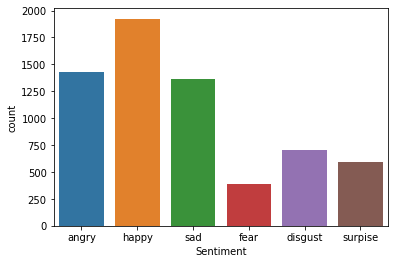

In [7]:
sns.countplot(df['Sentiment'])

In [8]:
df.Sentiment.value_counts(), len(df)

(happy      1924
 angry      1427
 sad        1366
 disgust     704
 surpise     592
 fear        392
 Name: Sentiment, dtype: int64, 6405)

In [9]:
maxlen = 200
max_features = 10000
batch_size = 32

In [20]:
df['Text']=df['Text'].astype('str')

In [21]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['Text'],df['Label'] , test_size=0.1, random_state=42)
x_train, x_validation, y_train, y_validation = train_test_split(df['Text'],df['Label'],test_size=0.1, random_state=2)

In [24]:
vocab_size=15000

In [25]:
tokenizer  = Tokenizer(num_words = max_features,oov_token = "<OOV>")
tokenizer.fit_on_texts(df['Text'])

train_seq =  tokenizer.texts_to_sequences(x_train)
val_seq =  tokenizer.texts_to_sequences(x_validation)
test_seq = tokenizer.texts_to_sequences(x_test)

In [26]:
x_train = pad_sequences(train_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post') #maxlen = maxlen, padding='post')
x_validation = pad_sequences(val_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post') #maxlen = maxlen, padding='post')
x_test = pad_sequences(test_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post') #maxlen = maxlen, padding='post')

In [29]:
model= Sequential()
model.add(Embedding(vocab_size,40,input_length=maxlen,name='Embedding'))
model.add(Conv1D(200, kernel_size=3, activation = "relu"))
model.add(Bidirectional(LSTM(128, return_sequences=True)))
model.add(Dropout(0.25))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(12, activation='relu'))
model.add(Flatten())
model.add(Dense(units=6, activation='softmax'))
adam=Adam(learning_rate=0.003)
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer=adam,metrics=['accuracy'])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding (Embedding)       (None, 200, 40)           600000    
                                                                 
 conv1d (Conv1D)             (None, 198, 200)          24200     
                                                                 
 bidirectional (Bidirectiona  (None, 198, 256)         336896    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 198, 256)          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [30]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=30, verbose=1, validation_data=(x_validation, y_validation))

Epoch 1/30
181/181 [==============================] - 43s 166ms/step - loss: 1.6060 - accuracy: 0.3270 - val_loss: 1.4629 - val_accuracy: 0.4290
Epoch 2/30
181/181 [==============================] - 28s 155ms/step - loss: 1.4903 - accuracy: 0.4051 - val_loss: 1.4532 - val_accuracy: 0.4462
Epoch 3/30
181/181 [==============================] - 28s 154ms/step - loss: 1.3411 - accuracy: 0.4615 - val_loss: 1.5345 - val_accuracy: 0.4493
Epoch 4/30
181/181 [==============================] - 28s 152ms/step - loss: 1.2480 - accuracy: 0.4950 - val_loss: 1.5008 - val_accuracy: 0.4384
Epoch 5/30
181/181 [==============================] - 28s 153ms/step - loss: 1.1430 - accuracy: 0.5371 - val_loss: 1.5321 - val_accuracy: 0.4524
Epoch 6/30
181/181 [==============================] - 27s 151ms/step - loss: 1.0425 - accuracy: 0.5810 - val_loss: 1.6682 - val_accuracy: 0.4243
Epoch 7/30
181/181 [==============================] - 27s 149ms/step - loss: 0.9192 - accuracy: 0.6310 - val_loss: 1.7462 - val_ac

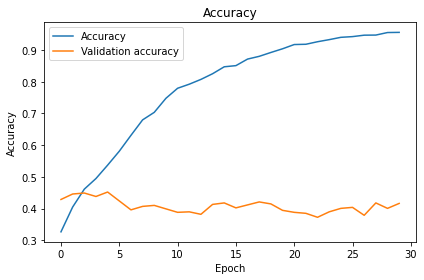

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

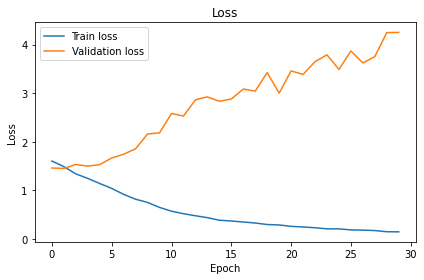

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Train loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [33]:
from sklearn.metrics import classification_report

y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred,axis=1)

In [34]:
print(y_test.shape)
print(y_pred.shape)

(641,)
(641,)


In [35]:
print(y_pred)
print(y_test)

[3 5 4 0 4 0 0 0 3 4 4 3 3 4 3 1 3 4 4 3 4 5 5 3 0 0 1 0 1 1 3 0 4 4 3 3 0
 4 3 4 0 4 4 0 4 1 0 0 3 0 3 3 3 0 3 0 0 4 0 0 3 3 2 4 4 3 3 4 4 0 3 4 4 4
 0 4 1 3 0 0 4 3 3 0 3 0 0 3 3 3 3 4 4 0 4 1 0 3 3 4 2 0 0 0 3 0 3 4 4 4 3
 4 3 4 3 4 3 4 4 0 5 5 5 0 3 3 4 3 3 3 1 3 0 3 4 0 2 1 0 4 4 2 4 3 3 1 3 3
 4 3 3 2 3 3 0 2 4 3 1 5 3 0 0 3 2 4 3 0 3 0 3 3 0 1 4 1 0 5 5 3 2 0 0 4 3
 4 0 4 0 3 4 3 4 1 4 4 4 3 3 5 5 2 4 0 5 5 2 5 4 3 4 5 5 3 1 5 2 0 4 0 3 3
 1 3 4 0 4 3 1 0 1 4 5 3 3 1 3 1 0 4 3 3 5 3 4 1 3 1 3 1 3 0 3 0 4 0 4 5 3
 3 3 5 4 3 0 2 5 2 3 4 3 3 5 1 1 4 5 0 5 1 2 1 0 1 4 1 4 3 3 3 4 3 3 1 2 0
 5 0 3 0 5 3 1 0 0 4 0 1 3 0 0 2 3 3 1 1 3 4 5 2 1 1 4 2 4 4 0 1 3 4 3 5 3
 2 3 3 3 1 2 4 5 2 5 1 3 0 0 0 4 4 3 4 3 3 3 3 0 3 4 3 4 0 3 0 4 2 3 4 4 0
 0 4 1 0 1 4 3 3 3 3 4 0 4 4 4 0 3 4 0 0 2 0 2 3 5 0 0 0 4 5 4 0 3 4 3 3 0
 0 3 3 2 5 2 4 4 0 4 3 1 3 0 4 4 3 3 2 1 5 1 5 5 0 0 3 3 0 5 4 3 0 5 2 2 0
 3 3 4 3 3 5 4 5 4 4 3 0 2 3 1 2 4 4 4 3 4 4 0 0 4 0 3 1 3 1 0 0 4 0 4 4 4
 1 3 0 3 4 4 1 1 0 4 3 3 

In [36]:
y_pred = y_pred.reshape(-1,1)

In [37]:
categories = ['sad', 'angry','surprise','happy','fear','disgust']
print(classification_report(y_test, y_pred, target_names=categories))

              precision    recall  f1-score   support

         sad       0.91      0.92      0.92       138
       angry       0.90      0.73      0.81        74
    surprise       0.90      0.84      0.87        45
       happy       0.96      0.98      0.97       178
        fear       0.90      0.94      0.92       156
     disgust       0.84      0.92      0.88        50

    accuracy                           0.91       641
   macro avg       0.90      0.89      0.89       641
weighted avg       0.91      0.91      0.91       641



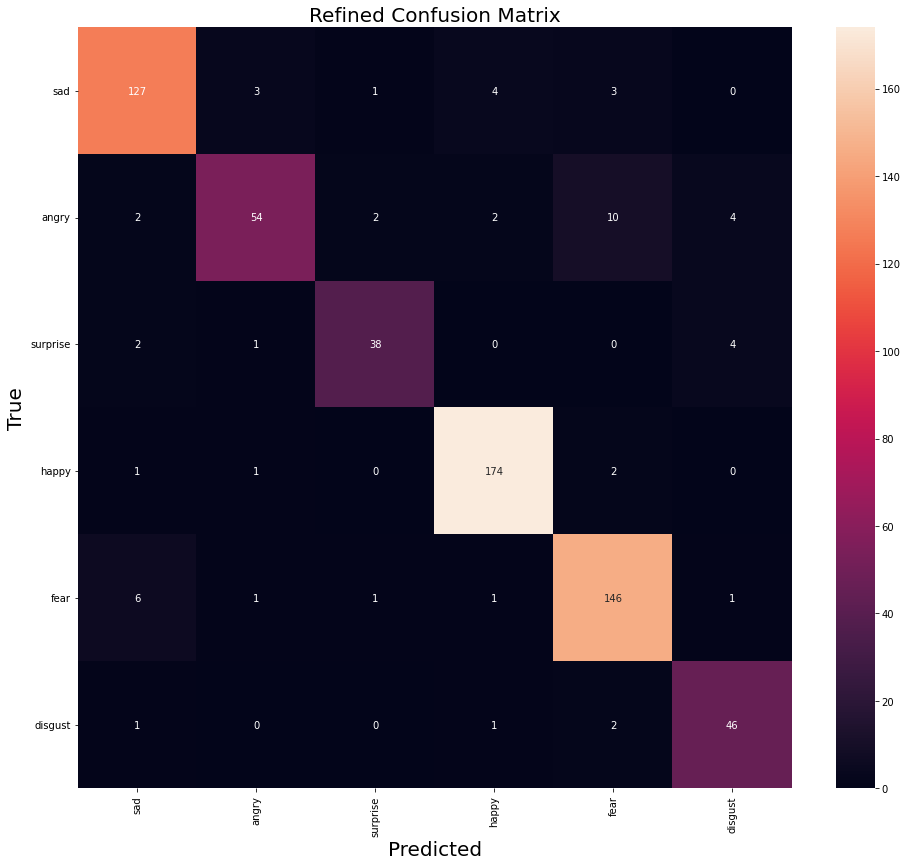

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

### Confusion Matrix
from sklearn.metrics import confusion_matrix
#predictions = model.predict(x_test, steps=len(x_test), verbose=0)
#y_pred=model.predict(x_test)
#y_pred = np.round(y_pred)


cm = confusion_matrix(y_test, y_pred)

## Get Class Labels
labels = 6
#[0,1,2,3,4,5]_
class_names = categories 

# Plot confusion matrix in a beautiful manner
fig = plt.figure(figsize=(16, 14))
ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt = 'g'); #annot=True to annotate cells
# labels, title and ticks
ax.set_xlabel('Predicted', fontsize=20)
ax.xaxis.set_label_position('bottom')
plt.xticks(rotation=90)
ax.xaxis.set_ticklabels(class_names, fontsize = 10)
ax.xaxis.tick_bottom()

ax.set_ylabel('True', fontsize=20)
ax.yaxis.set_ticklabels(class_names, fontsize = 10)
plt.yticks(rotation=0)

plt.title('Refined Confusion Matrix', fontsize=20)

plt.savefig('ConMat24.png')
plt.show()
